# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

##  Откроем файл с данными и изучим общую информацию

In [1]:
import numpy as np
import pandas as pd
import seaborn

df = pd.read_csv('/datasets/data.csv')

df.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Датасет содержит 
Типы данных в столбцах соответствуют их содержанию. Но количество значений в столбцах различается. Значит, в данных есть пропущенные значения.



In [3]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


**Выводы**

1. В каждой строке таблицы — данные о заёмщике банковского кредита. В таблице есть как информация о самом кредите (цель получения кредита), так и информация о заемщике: его кредитная история, ежемесячный доход, пол, возраст, семейное положение, уровень образования. 

2. В данных встречаются пропуски: датафрейм содержит 21525, а количество заполенных значений в столбцах `days_employed` и `total_income` одинаково и равно 19351. Возможно, отсутствие данных о ежемесячном доходе как-то связано с пропущенными значениями в столбце с информацией о трудовом стаже заёмщиков.

3. В столбце `children`, содержащем информацию о количестве детей заёмщика, встречаются аномальные значения: минимальное число  равно -1, а максимальное - 20. Вероятно, при вводе данных были допущены опечатки. 

4. В столбце `days_employed`, содержащем информацию о трудовом стаже заёмщика в днях, встречаются отрицательные значения. Скорее всего, это связано с тем, что стаж считается в отрицательную сторону, и правильно взять значения по модулю. Максимальное значение в этом столбце, если считать, что данные записаны в днях, равно почти 401755, а это 1101 год. Вероятно, эти данные записаны в часах.

5. В столбце `dob_years`, содержащем информацию о возрасте клиента в годах, минимальное значение равно 0. Оно некорректно, нужно проверить, сколько таких ячеек. 

Количество заполенных значений в столбцах `days_employed` и `total_income` одинаково и равно 19351. Проверим, связано ли отсутствие данных о ежемесячном доходе с пропущенными значениями в столбце с информацией о трудовом стаже заёмщиков.

In [4]:
df[(df['days_employed'].isnull()) & (df['total_income'].isnull())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 12 to 21510
Data columns (total 12 columns):
children            2174 non-null int64
days_employed       0 non-null float64
dob_years           2174 non-null int64
education           2174 non-null object
education_id        2174 non-null int64
family_status       2174 non-null object
family_status_id    2174 non-null int64
gender              2174 non-null object
income_type         2174 non-null object
debt                2174 non-null int64
total_income        0 non-null float64
purpose             2174 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 220.8+ KB


Видно, что пропущенные пропущенные значения в столбце `total_income` соответствуют пропускам в столбце `days_employed`. Вероятно, это связано с тем, что часть заёмщиков, например студенты, работает неофициально.

## Предобработка данных

### Обработка пропусков
Посчитаем, сколько в таблице пропущенных значений:

In [5]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Также оценим долевое соотношение пропусков относительно общей длины датафрейма:

In [6]:
df.isna().mean()

children            0.000000
days_employed       0.100999
dob_years           0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.100999
purpose             0.000000
dtype: float64

Видим, что количество пропущенных значений в столбце, содержащем информацию о трудовом стаже (`days_employed`), и в столбце с данными о ежемесячном доходе заёмщика (`total_income`), превышает 10% от общей длины датафрема. Такое число пропусков повлияет на данные исследования.

Ежемесяный доход и трудовой стаж - количественные переменные. Поэтому пропуски в них заполним медианными значениями, так как среднее значение не всегда корректно характеризует выборку: некоторые значения могут сильно выделяться среди большинства.

1. Сначала заполним пропуски в столбце `total_income`. 

Уровень доходов человека зависит от его типа занятости. Выведем все уникальные значения столбца `total_income`:

In [7]:
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

Видим, что в числе заёмщиков есть как безработные и пенсионеры, так и госслужащие и предприниматели. Вероятно, предствители каждой из этих категорий имеют разный уровень дохода. И для адекватного заполения пропусков найдем медианное значение столбца `total_income` для каждой из этих подгрупп.

In [8]:
median_income = df.groupby('income_type')['total_income'].median()
display(median_income.sort_values())

income_type
в декрете           53829.130729
студент             98201.625314
пенсионер          118514.486412
безработный        131339.751676
сотрудник          142594.396847
госслужащий        150447.935283
компаньон          172357.950966
предприниматель    499163.144947
Name: total_income, dtype: float64

Действительно, уровень дохода зависит от трудового статуса человека: наименьший доход - у сотрудников в декрете, наибольший - у предпринимателей.

Создадим функцию, с помощью которой заполним пропущенные значения в столбце `total_income` в зависимости от типа занятости заёмщика:

In [9]:
dict_type = {'в декрете': median_income[1],
            'студент': median_income[7],
            'пенсионер': median_income[4],
            'безработный': median_income[0],
            'сотрудник': median_income[6],
            'госслужащий': median_income[2],
            'компаньон': median_income[3],
            'предприниматель': median_income[5]}

def fill_type(row):
    
    type_job = row['income_type']
    income = row['total_income']
    
    if np.isnan(income):
        for key in dict_type:
            if key == type_job:
                return dict_type.get(key)
    else:
        return income

In [10]:
df['total_income'] = df.apply(fill_type, axis=1)

In [11]:
df.head(100)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,-541.832241,51,высшее,0,женат / замужем,0,F,сотрудник,0,94187.878082,автомобиль
96,0,NaN,44,СРЕДНЕЕ,1,женат / замужем,0,F,сотрудник,0,142594.396847,покупка жилой недвижимости
97,0,NaN,47,высшее,0,женат / замужем,0,F,сотрудник,0,142594.396847,профильное образование
98,0,364906.205736,54,высшее,0,женат / замужем,0,F,пенсионер,0,199707.298524,покупка жилья для сдачи


2. Заполним пропуски в столбце `days_employed`.

Трудовой стаж - суммарная продолжительность трудовой деятельности. Очевидно, что он напрямую зависит от возраста: чем человек старше, тем стаж больше. Для заполнения пропущенных значений в этом столбце распределим заёмщиков по возрастным категориям, а затем заполним пропуски медианными значениями для каждой из подгрупп.  
Для объединения данных в категории для начала определим возрастной диапазон, в котором находятся заёмщики. Выведем максимальное и минимальное значения столбца `dob_years`:

In [12]:
df['dob_years'].max(), df['dob_years'].min()

(75, 0)

Минимальное значение возраста заёмщика равно 0. Оно некорректно. Посмотрим, сколько таких ячеек и какой тип занятости имеют заёмщики с нулевым возрастом.

In [13]:
display('Количество заёмщиков с возрастом, равным 0: ' + str(df[df['dob_years'] == 0].count()[0]))

df.loc[df['dob_years'] == 0, 'income_type'].value_counts()

'Количество заёмщиков с возрастом, равным 0: 101'

сотрудник      55
пенсионер      20
компаньон      20
госслужащий     6
Name: income_type, dtype: int64

Итак, общее количество нулевых значений возраста равно 101. Для более точного заполнения пропусков в столбце `days_employed` сначала исправим эти нулевые значения.

Видим, что наибольшее количество ячеек с некорректным возрастом у сотрудников организаций. Исправим все некорректные значения на медианные столбца `dob_years` для каждого типа занятости.

In [14]:
median_age = df.groupby('income_type')['dob_years'].median()
display(median_age.sort_values())

income_type
студент            22.0
безработный        38.0
в декрете          39.0
компаньон          39.0
сотрудник          39.0
госслужащий        40.0
предприниматель    42.5
пенсионер          60.0
Name: dob_years, dtype: float64

Создадим функцию, с помощью которой заполним нулевые значения в столбце `dob_years` в зависимости от типа занятости заёмщика:

In [15]:
dict_type = {'в декрете': median_age[1],
            'студент': median_age[7],
            'пенсионер': median_age[4],
            'безработный': median_age[0],
            'сотрудник': median_age[6],
            'госслужащий': median_age[2],
            'компаньон': median_age[3],
            'предприниматель': median_age[5]}

def fill_age(row):
    
    type_job = row['income_type']
    age = row['dob_years']
    
    if age == 0:
        for key in dict_type:
            if key == type_job:
                return dict_type.get(key)
    else:
        return age

In [16]:
df['dob_years'] = df.apply(fill_age, axis=1)

Проверим, сколько осталось ячеек с некорректным возрастом:

In [17]:
display('Количество заёмщиков с возрастом, равным 0: ' + str(df[df['dob_years'] == 0].count()[0]))

df.loc[df['dob_years'] == 0, 'income_type'].value_counts()

'Количество заёмщиков с возрастом, равным 0: 0'

Series([], Name: income_type, dtype: int64)

Теперь можно приступать к заполнению пропусков в столбце `days_employed`.

Официально получать кредитные средства можно лицам от 18 лет. Выделим четыре возрастные категории:
1) от 18 до 24

2) от 25 до 34

3) от 35 до 59

4) с 60 до 75

Для адекватного заполения пропусков найдем медианные значения столбца `days_employed` для каждой возрастной категории.

Сначала создадим функцию, с помощью которой распределим заёмщиков по возрастным категориям, выделенным выше:

In [18]:
def age_group(age):
    
    if age <= 24:
        return '18-24'

    if age >= 25 and age <= 34:
        return '25-34'

    if age >= 35 and age <= 59:
        return '35-59'
    
    if age >= 60 and age <= 75:
        return '60-75'

df['age_group'] = df['dob_years'].apply(age_group)

df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,-8437.673028,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,35-59
1,1,-4024.803754,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,35-59
2,0,-5623.422610,33.0,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,25-34
3,3,-4124.747207,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,25-34
4,0,340266.072047,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,35-59
5,0,-926.185831,27.0,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,25-34
6,0,-2879.202052,43.0,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем,35-59
7,0,-152.779569,50.0,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование,35-59
8,2,-6929.865299,35.0,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы,35-59
9,0,-2188.756445,41.0,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи,35-59


In [19]:
median_days_empl = df.groupby('age_group')['days_employed'].median()
display(median_days_empl.sort_values())

age_group
35-59     -1587.646022
25-34     -1280.124639
18-24      -744.016267
60-75    355324.823353
Name: days_employed, dtype: float64

В данных столбца `days_employed`, помимо 10% пропущенных значений, обнаружены следующие проблемы:

1) Видим, что встречаются отрицательные значения трудового стажа. Скорее всего, стаж считается в отрицательную сторону, и правильно взять значения по модулю. 

2) В возрастной категории `60 - 75` медианное значение трудового стажа равно примерно 973 годам, если считать, что данные записаны в днях. Значение неадекватное и скорее всего, некторые из них были записаны в часах. Проверим эту гипотезу:

In [20]:
'Максимальное значение трудового стажа равно: '+ str((df['days_employed'].max()/(24*365)).round()) + ' годам'

'Максимальное значение трудового стажа равно: 46.0 годам'

In [21]:
'Возраст заёмщика с максимальным стажем равен: ' + str(df.loc[df['days_employed'].idxmax(), 'dob_years']) + ' годам'

'Возраст заёмщика с максимальным стажем равен: 56.0 годам'

Получается, человек начал работать в 10 лет. Это настораживает, т.к. официально в России трудовую книжку граждане имеют право заводить с 14 лет. Несмотря на эту странность, считаем, что гипотеза подтвердилась.

1. Сперва исправим все отрицательные значения столбца `days_employed`.

Возьмем значения столбца `days_employed` по модулю:

In [22]:
df['days_employed'] = df['days_employed'].abs()

2. Затем исправим аномально большие значения столбца `days_employed`.

Проверим, только ли в возрастной категории `60 - 75` проблемы с данными. Для этого выведем максимальное значение трудового стажа для каждой категории:

In [23]:
groups = df['age_group'].unique()
for group in groups:
    display('Максимальное значение трудового стажа для возрастной категории ' + group + ' равно ' + str(df[df['age_group'] == group].max()['days_employed'])) 

'Максимальное значение трудового стажа для возрастной категории 35-59 равно 401755.40047533'

'Максимальное значение трудового стажа для возрастной категории 25-34 равно 397905.00319993024'

'Максимальное значение трудового стажа для возрастной категории 60-75 равно 401715.8117488882'

'Максимальное значение трудового стажа для возрастной категории 18-24 равно 334764.25983126624'

Видим, что аномальные значения содержатся в каждой из категорий. Посмотрим на точечные графики распредления трудового стажа по возрасту для каждой из подгрупп.

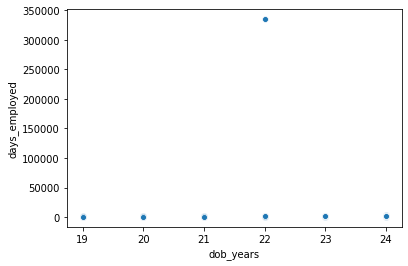

In [24]:
seaborn.scatterplot(data = df[df['age_group'] == '18-24'], x='dob_years', y='days_employed')

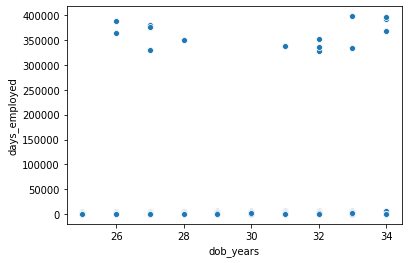

In [25]:
seaborn.scatterplot(data = df[df['age_group'] == '25-34'], x='dob_years', y='days_employed');

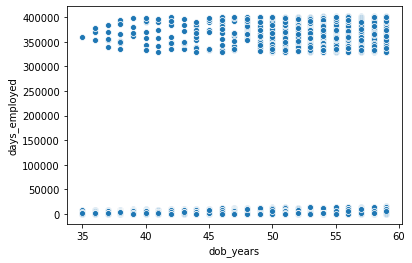

In [26]:
seaborn.scatterplot(data = df[df['age_group'] == '35-59'], x='dob_years', y='days_employed');

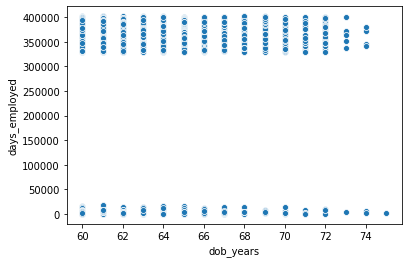

In [27]:
seaborn.scatterplot(data = df[df['age_group'] == '60-75'], x='dob_years', y='days_employed');

Из графиков видно, что аномальные значения трудового стажа содержатся во всех возрастных категориях и только для возрастной группы `18-24` его можно считать выбросом, в остальных случаях ввод этих аномальных данных производился систематически. Скорее всего, это подтверждает гипотезу о том, что данные о трудовом стаже для некоторой части заёмщиков были записаны не в днях, как говорится в описании данных от заказчика, а в часах. Для приведения данных в столбце `days_employed` к одним единицам измерения (дням) разделим ячейки, превышающие значения 150000 на 24.

In [28]:
df.loc[(pd.isnull(df['days_employed']) == False) & (df['days_employed'] > 150000), 'days_employed'] = df['days_employed']/24

df.head(100)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,8437.673028,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,35-59
1,1,4024.803754,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,35-59
2,0,5623.422610,33.0,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,25-34
3,3,4124.747207,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,25-34
4,0,14177.753002,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,35-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,541.832241,51.0,высшее,0,женат / замужем,0,F,сотрудник,0,94187.878082,автомобиль,35-59
96,0,NaN,44.0,СРЕДНЕЕ,1,женат / замужем,0,F,сотрудник,0,142594.396847,покупка жилой недвижимости,35-59
97,0,NaN,47.0,высшее,0,женат / замужем,0,F,сотрудник,0,142594.396847,профильное образование,35-59
98,0,15204.425239,54.0,высшее,0,женат / замужем,0,F,пенсионер,0,199707.298524,покупка жилья для сдачи,35-59


И теперь определим медианные значения трудового стажа для каждой возрасной категории:

In [29]:
median_days_empl = df.groupby('age_group')['days_employed'].median().round()
display(median_days_empl.sort_values())

age_group
18-24      745.0
25-34     1292.0
35-59     2510.0
60-75    14816.0
Name: days_employed, dtype: float64

Создадим функцию, с помощью которой заполним пропущенные значения в столбце `days_employed`в зависимости от возраста заёмщика:

In [30]:
dict_age_empl = {'18-24': median_days_empl[0],
            '25-34': median_days_empl[1],
            '35-59': median_days_empl[2],
            '60-75': median_days_empl[3]}

def fill_days(row):
    
    age_group = row['age_group']
    days_empl = row['days_employed']
    
    if np.isnan(days_empl):
        for key in dict_age_empl:
            if key == age_group:
                return dict_age_empl.get(key)
    else:
        return days_empl

In [31]:
df['days_employed'] = df.apply(fill_days, axis=1)

In [32]:
df.head(100)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,8437.673028,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,35-59
1,1,4024.803754,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,35-59
2,0,5623.422610,33.0,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,25-34
3,3,4124.747207,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,25-34
4,0,14177.753002,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,35-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,541.832241,51.0,высшее,0,женат / замужем,0,F,сотрудник,0,94187.878082,автомобиль,35-59
96,0,2510.000000,44.0,СРЕДНЕЕ,1,женат / замужем,0,F,сотрудник,0,142594.396847,покупка жилой недвижимости,35-59
97,0,2510.000000,47.0,высшее,0,женат / замужем,0,F,сотрудник,0,142594.396847,профильное образование,35-59
98,0,15204.425239,54.0,высшее,0,женат / замужем,0,F,пенсионер,0,199707.298524,покупка жилья для сдачи,35-59


Проверим, что все пропущенные значения в таблице заполнены:

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
children            21525 non-null int64
days_employed       21525 non-null float64
dob_years           21525 non-null float64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
age_group           21525 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 2.1+ MB


Все пропущенные значения датафрейме заполнены.

### Исправление аномальных значений

Выведем уникальные значения столбца `children`:

In [34]:
df['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

Посмотрим на распределение этих значений по возрастным категориям:

In [35]:
df.loc[df['children'] == 20, 'age_group'].value_counts()

35-59    50
25-34    18
60-75     5
18-24     3
Name: age_group, dtype: int64

In [36]:
df.loc[df['children'] == -1, 'age_group'].value_counts()

35-59    28
25-34    14
60-75     4
18-24     1
Name: age_group, dtype: int64

Видим, что в столбце children, содержащем информацию о количестве детей заёмщика, встречаются аномальные значения: минимальное число равно -1, а максимальное - 20. Вероятно, при вводе данных были допущены опечатки и действительное количество детей равно 1 и 2. Исправим данные в датафрейме:

In [37]:
df.loc[(df['children'] == 20) , 'children'] = 2
df.loc[(df['children'] == -1) , 'children'] = 1

**Выводы**
 
1.  Пропущенные значения в столбце `total_income` были заменены на медианные значения уровня дохода в зависимости от типа занятости заёмщика. 

2. Отрицательные значения в столбце `days_employed` были взяты по модулю. Также было выявлено, что аномально большие значения трудового стажа были записаны в часах для некоторых заёмщиков, поэтому эти значения были переведены в дни. Нулевые значения в столбце `dob_years`, содержащем информацию о возрасте заемщика, были заменены медианными значениями для каждого типа занятости.

2. Пропущенные значения в столбце `days_employed` были заменены на медианные значения трудового стажа в зависимости от возраста заёмщика. Для этого были выделены четыре возрастные категории.  

3. В столбце `children`, содержащем информацию о количестве детей заёмщика, встречались аномальные значения: минимальное число  равно -1, а максимальное - 20. Количество таких значений выделялось из общей выборки, а значит, ошибки были допущены при вводе данных. Эти значения были заменены на 1 и 2, соответственно.  

5. В столбце `dob_years`, содержащем информацию о возрасте клиента в годах, минимальное значение равно 0. Оно некорректно, нужно проверить, сколько таких ячеек. 

### Изменение типов данных

### Изменение типов данных

Из таблицы, представленной выше, видно, что столбец `days_employed`, содержащий информацию о трудовом стаже в днях, и `dob_years`, содержащий возраст заёмщика, записаны вещественным числом. Изменим эти данные на целочисленные:

In [38]:
df['days_employed'] = df['days_employed'].astype(int)
df['dob_years'] = df['dob_years'].astype(int)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
age_group           21525 non-null object
dtypes: float64(1), int64(6), object(6)
memory usage: 2.1+ MB


In [40]:
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,35-59
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,35-59
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,25-34
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,25-34
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,35-59
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,25-34
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем,35-59
7,0,152,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование,35-59
8,2,6929,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы,35-59
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи,35-59


Данные в столбцах с информацией о трудовом стаже в днях и возрасте заёмщиков, были изменены на целочисленные значения. 

### Обработка дубликатов

Перед поиском дубликатов в данных таблицы приведем все символы в столбцах, содержащих данные строкового типа, к нижнему регистру:

In [41]:
df['education'] = df['education'].str.lower()

df['family_status'] = df['family_status'].str.lower()

df['income_type'] = df['income_type'].str.lower()

df['purpose'] = df['purpose'].str.lower()

Посчитаем суммарное количество дубликатов в датафрейме:

In [42]:
df.duplicated().sum()

71

Выведем строки, содержащие одинаковую информацию:

In [43]:
df[df[['children', 'days_employed', 'dob_years', 'education', 'family_status', 'family_status_id', 'gender', 'income_type', 'debt', 'total_income', 'purpose', 'age_group']].duplicated() == True].sort_values(by = 'days_employed')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
20297,1,745,23,среднее,1,гражданский брак,1,F,сотрудник,0,142594.396847,сыграть свадьбу,18-24
19321,0,745,23,среднее,1,не женат / не замужем,4,F,сотрудник,0,142594.396847,сделка с подержанным автомобилем,18-24
13878,1,1292,31,среднее,1,женат / замужем,0,F,компаньон,0,172357.950966,покупка жилья,25-34
21281,1,1292,30,высшее,0,женат / замужем,0,F,сотрудник,0,142594.396847,покупка коммерческой недвижимости,25-34
4182,1,1292,34,высшее,0,гражданский брак,1,F,сотрудник,0,142594.396847,свадьба,25-34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,0,14816,62,среднее,1,женат / замужем,0,F,пенсионер,0,118514.486412,ремонт жилью,60-75
17338,0,14816,64,среднее,1,гражданский брак,1,F,пенсионер,0,118514.486412,сыграть свадьбу,60-75
18428,0,14816,64,среднее,1,женат / замужем,0,F,пенсионер,0,118514.486412,жилье,60-75
9528,0,14816,66,среднее,1,вдовец / вдова,2,F,пенсионер,0,118514.486412,операции со своей недвижимостью,60-75


Удалим дубликаты:

In [44]:
df = df.drop_duplicates().reset_index(drop = True)

Проверим, исчезли ли дубликаты:

In [45]:
df.duplicated().sum()

0

Все дубликаты удалены.

### Лемматизация

Выведем уникальные значения списка `purpose`, содержащий цели взятия кредита:

In [46]:
df['purpose'].value_counts()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
жилье                                     646
покупка жилья                             646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

Видим, что многие цели взятия кредита по смыслу дублируют друг друга. Поэтому выделим леммы в значениях столбца `purpose` для дальнейшей категоризации данных по целям выдачи кредита. 

Выделим леммы и выведем их в виде словаря, элементы которого расположены в порядке уменьшения количества упоминания. 

In [47]:
import pandas as pd
from pymystem3 import Mystem
m = Mystem() 
from collections import Counter

purposes = df['purpose']
purpose_unique = []

for purpose in purposes:
    
    lemma = m.lemmatize(purpose)
    purpose_unique.append(lemma)
    
result = []    
for i in range (len(purpose_unique)):
    for j in range (len(purpose_unique[i])):
        result.append(purpose_unique[i][j])
    
Counter(result).most_common()

[(' ', 33570),
 ('\n', 21454),
 ('недвижимость', 6351),
 ('покупка', 5897),
 ('жилье', 4460),
 ('автомобиль', 4306),
 ('образование', 4013),
 ('с', 2918),
 ('операция', 2604),
 ('свадьба', 2324),
 ('свой', 2230),
 ('на', 2222),
 ('строительство', 1878),
 ('высокий', 1374),
 ('получение', 1314),
 ('коммерческий', 1311),
 ('для', 1289),
 ('жилой', 1230),
 ('сделка', 941),
 ('дополнительный', 906),
 ('заниматься', 904),
 ('проведение', 768),
 ('сыграть', 765),
 ('сдача', 651),
 ('семья', 638),
 ('собственный', 635),
 ('со', 627),
 ('ремонт', 607),
 ('подержанный', 486),
 ('подержать', 478),
 ('приобретение', 461),
 ('профильный', 436)]

Выберем из лемматизированного словаря 8 целей, которые встречаются чаще других, при этом пробелы, служебные части речи, местоимения учитывать не будем. Тогда получим следующий список:

In [48]:
new_purpose = ['недвижимость', 'покупка', 'жилье', 'автомобиль', 'образование', 'операция', 'свадьба', 'строительство', 'коммерческий']

Существует множество целей взятия кредита, но все их можно разделить на две категории: потребительский кредит и кредит на развитие. Первая категория кредитов направлена на удовлетворение потребностей физических лиц, вторая - вложение денег в оборот для получения дополнительной прибыли. 

Выделим основные виды потребительских кредитов, встречающихся в датафрейме, и обозначим новые категории для каждой из целей:
1) на приобретение, строительство и других операций с недвижимостью - общее название - `жилищные кредиты`;

2) займы на покупку авто - общее название - `автокредиты`;

3) кредиты на образование - общее название - `обучение`;

4) кредиты на проведение свадеб - общее название - `свадьба`;

Кредиты на операции с коммерческой недвижимостью обозначим как `кредит на развитие`. Полученные средства чаще направляются на операции, предполагающие конечную прибыль. Эта прибыль, в большинстве случаев, и должна служить источником для погашения займа.

Тогда получим следующий список целей:

In [49]:
new_purpose = ['жилищный кредит', 'автокредит', 'обучение', 'свадьба', 'кредит на развитие']

**Вывод**

С помощью лемматизации были выделены основные цели в значениях столбца `purpose` для дальнейшей категоризации заёмщиков.

### Категоризация данных

Для ответы на вопросы заказчика необходимо категоризовать данные.

1. Категоризация данных по целям выдачи кредита.

Создадим функцию, с помощью которой распределим заёмщиков по целям, выделенным выше:


In [50]:
def purpose_group(purpose):
    
    lemma = m.lemmatize(purpose)

    if 'коммерческий' in lemma:
        return 'кредит на развитие'
    
    if 'недвижимость'in lemma or 'жилье' in lemma:
        return 'жилищный кредит'

    if 'автомобиль'in lemma:
        return 'автокредит'

    if 'образование'in lemma:
        return 'обучение'

    if 'свадьба'in lemma:
        return 'свадьба'

    
df['purpose_group'] = df['purpose'].apply(purpose_group)

df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group,purpose_group
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,35-59,жилищный кредит
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,35-59,автокредит
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,25-34,жилищный кредит
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,25-34,обучение
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,35-59,свадьба
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,25-34,жилищный кредит
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем,35-59,жилищный кредит
7,0,152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование,35-59,обучение
8,2,6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы,35-59,свадьба
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи,35-59,жилищный кредит


In [51]:
df['purpose_group'].value_counts()

жилищный кредит       9500
автокредит            4306
обучение              4013
свадьба               2324
кредит на развитие    1311
Name: purpose_group, dtype: int64

Итак, видно, что наиболее распространены жилищные кредиты, наименее - кредиты на развитие.

Проверим, что для всех заёмщиков ячейки с целями взятия кредита оказались заполены:

In [52]:
df['purpose_group'].isna().sum()

0

2. Категоризация заёмщиков по количеству детей.

Выделим три основные категории:

1) нет детей;

2) 1 - 2 ребенка;

3) многодетный/ая.

Создадим функцию, с помощью которой категоризуем данные:

In [53]:
def number_of_children(children):
    
    if children == 0:
        return 'нет детей'

    if children == 1 or children == 2:
        return '1-2'

    if children >= 3:
        return 'многодетный/ая'
    

df['number_of_children'] = df['children'].apply(number_of_children)

df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group,purpose_group,number_of_children
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,35-59,жилищный кредит,1-2
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,35-59,автокредит,1-2
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,25-34,жилищный кредит,нет детей
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,25-34,обучение,многодетный/ая
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,35-59,свадьба,нет детей
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,25-34,жилищный кредит,нет детей
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем,35-59,жилищный кредит,нет детей
7,0,152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование,35-59,обучение,нет детей
8,2,6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы,35-59,свадьба,1-2
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи,35-59,жилищный кредит,нет детей


In [54]:
df['number_of_children'].value_counts()

нет детей         14091
1-2                6983
многодетный/ая      380
Name: number_of_children, dtype: int64

Видим, что наибольшее число кредитов берут люди, не имеющие детей.

3. Категоризуем заёмщиков по уровню доходов.

Воспользуемся методом describe() для получения сводной статистики столбца `total_income`, содержащем информацию о ежемесячном доходе заёмщика:

In [55]:
summary_statistics = df['total_income'].describe()
display(summary_statistics)

count    2.145400e+04
mean     1.653201e+05
std      9.818730e+04
min      2.066726e+04
25%      1.076239e+05
50%      1.425944e+05
75%      1.958209e+05
max      2.265604e+06
Name: total_income, dtype: float64

Посмотрим на гистограмму доходов:

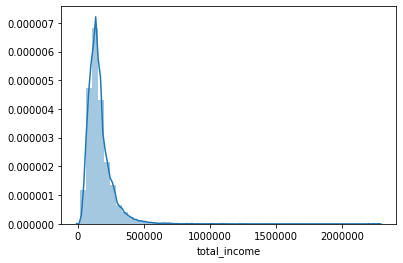

In [56]:
import seaborn 

income_plot = seaborn.distplot(df['total_income'])
fig_income = income_plot.get_figure()

Видим, что гистограмма смещена вправо, это значит, что существует ряд точек данных, превышающих моду.

Для выделения категорий по доходам воспользуемся квартилями - они делят данные на четыре равные части.

In [57]:
def level_of_income(total_income):
    
    if total_income <= summary_statistics[4]:
        return '25%'

    if total_income > summary_statistics[4] and total_income <= summary_statistics[5]:
        return '50%'

    if total_income > summary_statistics[5] and total_income <= summary_statistics[6]:
        return '75%'
    
    else:
        return '100%'

df['level_of_income'] = df['total_income'].apply(level_of_income)

df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group,purpose_group,number_of_children,level_of_income
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,35-59,жилищный кредит,1-2,100%
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,35-59,автокредит,1-2,50%
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,25-34,жилищный кредит,нет детей,75%
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,25-34,обучение,многодетный/ая,100%
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,35-59,свадьба,нет детей,75%
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,25-34,жилищный кредит,нет детей,100%
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем,35-59,жилищный кредит,нет детей,100%
7,0,152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование,35-59,обучение,нет детей,50%
8,2,6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы,35-59,свадьба,1-2,25%
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи,35-59,жилищный кредит,нет детей,75%


In [58]:
df['level_of_income'].value_counts()

50%     5479
100%    5364
25%     5364
75%     5247
Name: level_of_income, dtype: int64

Таким образом, заёмщики по уровню доходов распределяются следующим образом:

- 5479 из них имеют доход от 107624 рублей до 142594 рублей;
- 5364 из них имеют доход больше 195821 рублей;
- 5364 из них имеют доход меньше 107624 рублей;
- 5247 из них имеют доход от 142594 рублей до 195821 рублей.

4. Категоризация заёмщиков по семейному положению.

В исходных данных заёмщики уже были распределены по следующим категориям в зависимости от их семейного положения:

In [59]:
df_family_pivot = df.pivot_table(index = ['family_status'], values = 'family_status_id')
display(df_family_pivot)

,family_status_id
family_status,
в разводе,3
вдовец / вдова,2
гражданский брак,1
женат / замужем,0
не женат / не замужем,4


## Ответы на вопросы 

Для ответы на поставленные вопросы построим сводные таблицы.

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [60]:
children_pivot = df.pivot_table(index = ['number_of_children'], columns = 'debt', values = 'children', aggfunc = 'count')
children_pivot['sum'] = children_pivot[0]+children_pivot[1]
children_pivot['coeff'] = (children_pivot[1]/children_pivot['sum']).round(4)
display(children_pivot.sort_values(by = 'coeff'))

debt,0,1,sum,coeff
number_of_children,,,,
нет детей,13028,1063,14091,0.0754
многодетный/ая,349,31,380,0.0816
1-2,6336,647,6983,0.0927


**Вывод**

Из сводной таблицы видно, что чаще всего берут кредиты люди, не имеющие детей, у них же вероятность задолженности ниже. Наличие детей увеличивает вероятность задолженности по кредитам. Это вполне предсказуемо: дети увеличивают расходы, траты становятся необходимыми, а порой и непредвиденными. Интересно, что многодетные люди реже остальных берут кредиты и реже вынуждены нарушать условия договора по сравнению с теми, кто имеет 1 - 2 детей. Возможно, это объясняется тем, что таким семьям оказывается поддержка со стороны государства, редко возникает необходимость в новых вещах: часто вещи передаются от старших детей младшим. 

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [61]:
family_pivot = df.pivot_table(index = ['family_status'], columns = 'debt', values = 'dob_years', aggfunc = 'count')
family_pivot['sum'] = family_pivot[0]+family_pivot[1]
family_pivot['coeff'] = (family_pivot[1]/family_pivot['sum']).round(4)
display(family_pivot.sort_values(by = 'coeff'))

debt,0,1,sum,coeff
family_status,,,,
вдовец / вдова,896,63,959,0.0657
в разводе,1110,85,1195,0.0711
женат / замужем,11408,931,12339,0.0755
гражданский брак,3763,388,4151,0.0935
не женат / не замужем,2536,274,2810,0.0975


**Вывод**

Из сводной таблицы видим, что заёмщиками становятся чаще люди, состоящие в официальном браке. Они и те, кто хоть однажды состоял в зарегестрированных отношениях, менее склонны иметь задолженность по кредитам. Вероятно, такие люди ответственнее подходят к выплатам, более умело распоряжаются собственным бюджетом. На втором месте по частоте взятия кредита находятся те, кто состоит в "гражданском браке". Но, несмотря на то, что в этом случае, как и в случае официальных отношений, пары ведут совместный быт и оба партнера, как правило, имеют независимый доход, партнеры не несут ответственности за действия друг друга, и в случае разрыва отношений, кредит не делится пополам.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [62]:
income_pivot = df.pivot_table(index = ['level_of_income'], columns = 'debt', values = 'dob_years', aggfunc = 'count')
income_pivot['sum'] = income_pivot[0]+income_pivot[1]
income_pivot['coeff'] = (income_pivot[1]/income_pivot['sum']).round(4)
display(income_pivot.sort_values(by = 'coeff'))

debt,0,1,sum,coeff
level_of_income,,,,
100%,4981,383,5364,0.0714
25%,4937,427,5364,0.0796
75%,4799,448,5247,0.0854
50%,4996,483,5479,0.0882


**Вывод**

Из полученных результатов можно сделать вывод о том, что люди с разными уровнями достатка одинаково часто берут кредиты. Вполне ожидаемо, что те, кто имеет доход больше, чем 75% остальных представителей выборки, менее подвержены риску задолженности. Но любопытно, что заёмщики с наименьший доход вероятнее соблюдут условия договора. А вот люди со средним достатком более склонны становиться должниками.

- Как разные цели кредита влияют на его возврат в срок?

In [63]:
purpose_pivot = df.pivot_table(index = ['purpose_group'], columns = 'debt', values = 'dob_years', aggfunc = 'count')
purpose_pivot['sum'] = purpose_pivot[0]+purpose_pivot[1]
purpose_pivot['coeff'] = (purpose_pivot[1]/purpose_pivot['sum']).round(4)
display(purpose_pivot.sort_values(by = 'coeff'))

debt,0,1,sum,coeff
purpose_group,,,,
жилищный кредит,8817,683,9500,0.0719
кредит на развитие,1212,99,1311,0.0755
свадьба,2138,186,2324,0.0800
обучение,3643,370,4013,0.0922
автокредит,3903,403,4306,0.0936


**Вывод**

Итак, жилищный кредит наиболее популярен среди заёмщиков и они ответственне подходят к возврату задолженности. Хуже статистика по возврату кредита у тех, кто берет кредит на образование и на покупку автомобиля.

## Общий вывод

Итак, в ходе исследования надежности заёмщиков кредитного отдела банка нужно было разобраться, как влияют некоторые параметры, как то: семейное положение, наличие детей, уровень дохода и цели кредита, - на его возврат в срок. Были сделаны следующие выводы:

1) Наличие детей увеличивает вероятность задолженности по кредитам. Наиболее надежными заёмщиками по результатам анализа оказались те, кто не имеет детей.

2) Люди, состоящие или состоявшие хотя бы однажды в браке, обычно более дисциплинированно платят по долгам.

3) Заёмщики, имеющие доход больше, чем 75% остальных представителей выборки, меньше подвержены риску задолженности. А люди со средним достатком более склонны становиться должниками.

4) Наиболее надежными заёмщиками оказались те, целью кредита которых были операции с недвижимостью.